In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
from sklearn import metrics
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.dates as md
import time
from sklearn.inspection import permutation_importance

In [3]:
path = "/Users/zachgarberman/Desktop/Applied ML/Project Data/"
path = "/Users/pierre/Documents/Scolaire/MIT/Machine Learning/data/"
df = pd.read_csv(path + 'chicago_df.csv')

In [24]:
df_lin = df.copy()
df_lin['temperature'] = df_lin['temperature'] - 273.15
df_lin['hour_sq'] = df_lin['hour']**2
df_lin['hour_cub'] = df_lin['hour']**3
df_lin['hour_fourth'] = df_lin['hour']**4
df_lin['temperature_sq'] = df_lin['temperature']**2
df_lin['temperature_cub'] = df_lin['temperature']**3

One-Hot Encode, Test/Train Split

In [25]:
description_oh = pd.get_dummies(df_lin['description'], drop_first = True)
weekday_oh = pd.get_dummies(df_lin['dayofweek'], drop_first = True)
month_oh = pd.get_dummies(df_lin['month'], drop_first = True, prefix="Month")
df_2 = pd.concat([df_lin,description_oh,weekday_oh,month_oh],axis = 1)
df_2 = df_2.drop(['description','dayofweek','month'],axis=1)

In [26]:
X = df_2.iloc[:,2:]
y = df_2.iloc[:,0:1]

In [27]:
X_train = X.iloc[0:int(0.70*len(X)),]
y_train = y.iloc[0:int(0.70*len(X)),]
X_test = X.iloc[int(0.70*len(X)):,]
y_test = y.iloc[int(0.70*len(X)):,]

Linear Regression

In [28]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [29]:
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = reg.predict(X_test).reshape((m1,n1))
y_train_pred = reg.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.818618626331664
OS-R^2: 0.8057756952280277
IS-MAE: 658.610134747542
OS-MAE: 704.1248464415561
IS-RMSE: 882.8923827171346
OS-RMSE: 938.1276042710257


In [30]:
coefficients = dict(zip(X_train.columns, np.transpose(reg.coef_[0])))

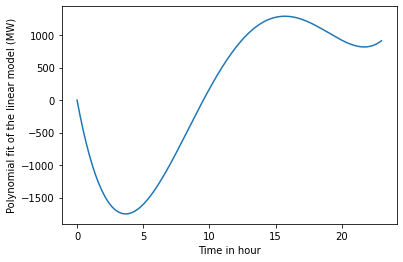

In [154]:
#coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)
c1, c2, c3, c4 = coefficients['hour'], coefficients['hour_sq'], coefficients['hour_cub'], coefficients['hour_fourth']
t = np.linspace(0, 23, 200)
plt.figure()
plt.plot(t, c1*t + c2*t**2 + c3*t**3 + c4*t**4)
plt.xlabel("Time in hour")
plt.ylabel("Polynomial fit of the linear model (MW)")
plt.savefig('figures/hour_of_the_day.png', dpi = 200)

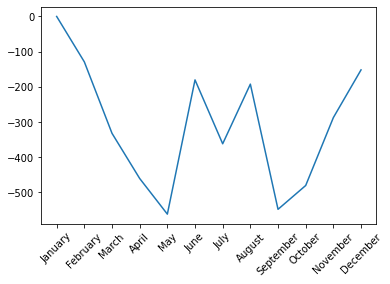

In [155]:
coef_month = [0]
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i in range(2,13):
    name = 'Month_' + str(i)
    coef_month += [coefficients[name]]
coef_month = np.array(coef_month)
plt.figure()
plt.plot(month, coef_month)
plt.xticks(rotation=45)
plt.show()

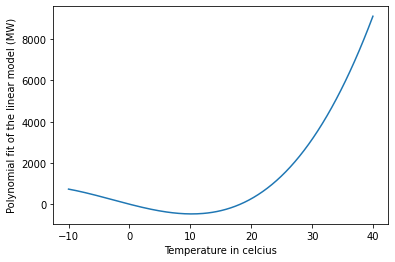

In [156]:
ctemperature1, ctemperature2, ctemperature3 = coefficients['temperature'], coefficients['temperature_sq'], coefficients['temperature_cub']
t = np.linspace(-10, 40, 200)
plt.figure()
plt.plot(t, ctemperature1*t + ctemperature2*t**2 + ctemperature3*t**3)
plt.xlabel("Temperature in celcius")
plt.ylabel("Polynomial fit of the linear model (MW)")
plt.savefig('figures/temperature.png', dpi = 200)

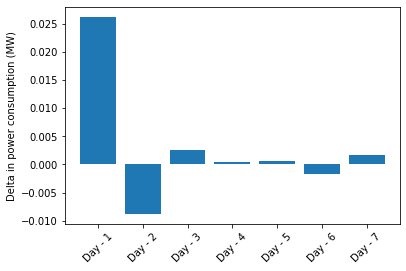

In [157]:
coef_lag = []
lags = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7']
lags_labels = ['Day - 1', 'Day - 2', 'Day - 3', 'Day - 4', 'Day - 5', 'Day - 6', 'Day - 7']
for lag in lags:
    coef_lag += [coefficients[lag]]
coef_lag = np.array(coef_lag)
plt.figure()
plt.bar(lags_labels, coef_lag)
plt.xticks(rotation=45)
plt.ylabel('Delta in power consumption (MW)')
plt.savefig('figures/lags.png', dpi = 200)

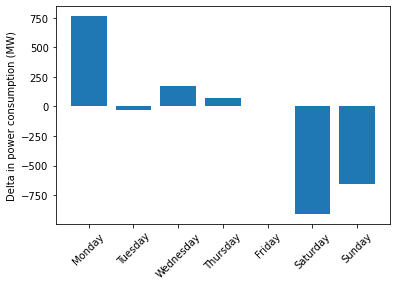

In [158]:
coef_lagDays = []
lagsDays_1 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
lagsDays_2 = ['Saturday', 'Sunday']
for lag in lagsDays_1:
    coef_lagDays += [coefficients[lag]]
coef_lagDays += [0]
for lag in lagsDays_2:
    coef_lagDays += [coefficients[lag]]
lagsDays = lagsDays_1 + ['Friday'] + lagsDays_2
coef_lagDays = np.array(coef_lagDays)
plt.figure()
plt.bar(lagsDays, coef_lagDays)
plt.xticks(rotation=45)
plt.ylabel('Delta in power consumption (MW)')
plt.savefig('figures/day_of_the_week.png', dpi = 200)

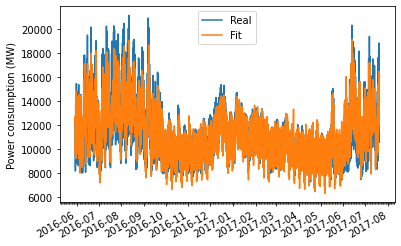

In [159]:
t_in = 0
t_out = 10000
timestamps = df_2.iloc[int(0.70*len(X)) + t_in:int(0.70*len(X)) + t_out,1]
power_fit = y_test_pred[t_in:t_out]
power_real = df_2.iloc[int(0.70*len(X)) + t_in:int(0.70*len(X)) + t_out,0]
df_timestamps = pd.to_datetime(timestamps)

fig, ax = plt.subplots()
ax.plot(df_timestamps, power_real, label = "Real")
ax.plot(df_timestamps, power_fit, label = "Fit")

# Major ticks every months.
fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_month)

# Minor ticks every week.
fmt_week = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_week)
fig.autofmt_xdate()
plt.ylabel('Power consumption (MW)')
plt.legend()

plt.savefig('figures/long_term_fit.png', dpi = 200)

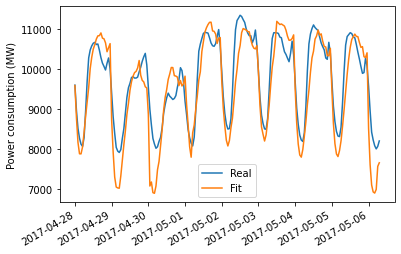

In [160]:
t_in = 8000
t_out = 8200
timestamps = df_2.iloc[int(0.70*len(X)) + t_in:int(0.70*len(X)) + t_out,1]
power_fit = y_test_pred[t_in:t_out]
power_real = df_2.iloc[int(0.70*len(X)) + t_in:int(0.70*len(X)) + t_out,0]
df_timestamps = pd.to_datetime(timestamps)

fig, ax = plt.subplots()
ax.plot(df_timestamps, power_real, label = "Real")
ax.plot(df_timestamps, power_fit, label = "Fit")

# Major ticks every day.
fmt_day = mdates.DayLocator(interval=1)
ax.xaxis.set_major_locator(fmt_day)

# Minor ticks every hour.
fmt_hour = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_hour)
#ax.grid(True)
fig.autofmt_xdate()
plt.ylabel('Power consumption (MW)')
plt.legend()
plt.savefig('figures/short_term_fit.png', dpi = 200)

Cross-Validated Ridge Regression

In [154]:
scaler = StandardScaler()
scaler.fit(X_train)
ridge_train = pd.DataFrame(scaler.transform(X_train))
ridge_test = pd.DataFrame(scaler.transform(X_test))

In [155]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(ridge_train):
    X_tr, X_val = ridge_train.iloc[tr_index,:], ridge_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for penalty in [10,5,2,1,0.1,0.01,0.001,0]:
        ridge = Ridge(alpha=penalty)
        ridge.fit(X_tr, y_tr)
        m,n = y_val.shape
        y_val_pred = ridge.predict(X_val).reshape((m,n))
        SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
        train_mean = np.mean(y_tr.to_numpy())
        SST = np.sum((train_mean - y_val_pred)**2)
        OSR2 = 1 - (SSR/SST)
        score.append([i,
                      penalty,
                      OSR2])
    i += 1

In [156]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "Lambda",2:"OSR2"})
cross_val = score.groupby(['Lambda']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

   Lambda      OSR2
1   0.001  0.707209


In [176]:
ridge_cv = Ridge(alpha=0.001).fit(ridge_train, y_train)
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = ridge_cv.predict(ridge_test).reshape((m1,n1))
y_train_pred = ridge_cv.predict(ridge_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.8186186086627556
OS-R^2: 0.8057618698237337
IS-MAE: 658.6119808833638
OS-MAE: 704.1308311039571
IS-RMSE: 882.8924257197426
OS-RMSE: 938.1354247056337


Cross-Validated CART

In [158]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for md in [2,4,6,8,10]:
        for mb in [100,150,200]:
            for alpha in [100,10,1,0.1]:
                cart = DecisionTreeRegressor(
                    max_depth=md,
                    min_samples_leaf=mb,
                    criterion = "mse",
                    ccp_alpha = alpha)
                cart.fit(X_tr, y_tr)
                m,n = y_val.shape
                y_val_pred = cart.predict(X_val).reshape((m,n))
                SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                train_mean = np.mean(y_tr.to_numpy())
                SST = np.sum((train_mean - y_val_pred)**2)
                OSR2 = 1 - (SSR/SST)
                score.append([i,
                            md,
                            mb,
                            alpha, 
                            OSR2])
    i += 1

In [159]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "Depth",2:"MinBucket", 3:"Alpha", 4:"OSR2"})
cross_val = score.groupby(['Depth','Alpha','MinBucket']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    Depth  Alpha  MinBucket      OSR2
48     10    0.1        100  0.513164
51     10    1.0        100  0.513164
54     10   10.0        100  0.513164


In [177]:
cart_cv = DecisionTreeRegressor(max_depth=10,min_samples_leaf=100,ccp_alpha=10).fit(X_train, y_train)
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = cart_cv.predict(X_test).reshape((m1,n1))
y_train_pred = cart_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.8515663456185867
OS-R^2: 0.800125317645711
IS-MAE: 546.9237345487588
OS-MAE: 686.9588986432983
IS-RMSE: 798.6888406018527
OS-RMSE: 1005.4444715635977


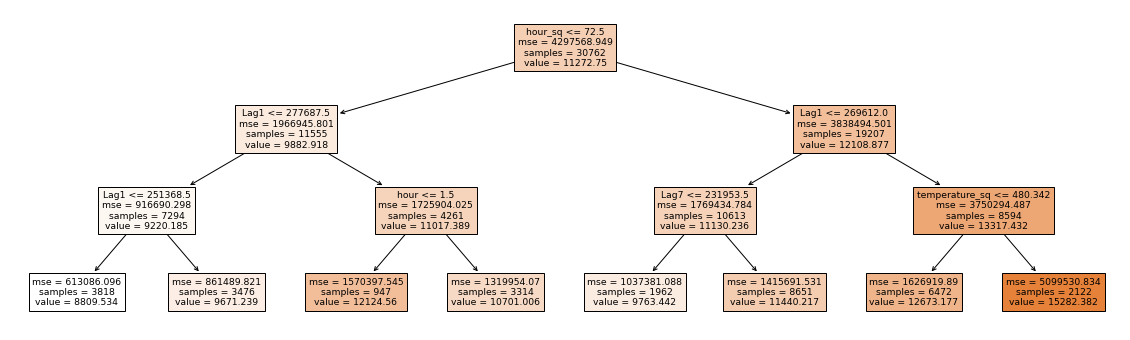

In [161]:
features = [i for i in X_test.columns]
cart_plot = DecisionTreeRegressor(max_depth=3,min_samples_leaf=100,ccp_alpha=10).fit(X_train, y_train)
plt.figure(figsize=(20, 6))
tree.plot_tree(cart_plot, filled=True,feature_names=features)
plt.show()

Cross-Validated Gradient Boosted Trees

In [162]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for lr in [0.1,0.01,0.001]:
        for trees in [50,100,150]:
            for md in [3,5,7]:
                for features in ["auto","sqrt","log2"]:
                    gbm = GradientBoostingRegressor(
                        learning_rate=lr,
                        n_estimators=trees,
                        max_depth=md,
                        max_features=features)
                    gbm.fit(X_tr, np.ravel(y_tr))
                    m,n = y_val.shape
                    y_val_pred = gbm.predict(X_val).reshape((m,n))
                    SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                    train_mean = np.mean(y_tr.to_numpy())
                    SST = np.sum((train_mean - y_val_pred)**2)
                    OSR2 = 1 - (SSR/SST)
                    score.append([i,
                                lr,
                                trees,
                                md, 
                                features,
                                OSR2])
    i += 1

In [163]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "LearningRate",2:"Trees", 
                                            3:"Depth", 4:"Features", 5:"OSR2"})
cross_val = score.groupby(['LearningRate','Trees','Depth','Features']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    LearningRate  Trees  Depth Features    OSR2
73           0.1    150      3     log2  0.6819


In [178]:
gbm_cv = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=5, 
                                max_features='sqrt').fit(X_train, np.ravel(y_train))
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = gbm_cv.predict(X_test).reshape((m1,n1))
y_train_pred = gbm_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.9496515825270001
OS-R^2: 0.8927420029078388
IS-MAE: 324.06724447514944
OS-MAE: 485.1018481962171
IS-RMSE: 465.16211752332026
OS-RMSE: 724.9269470055522


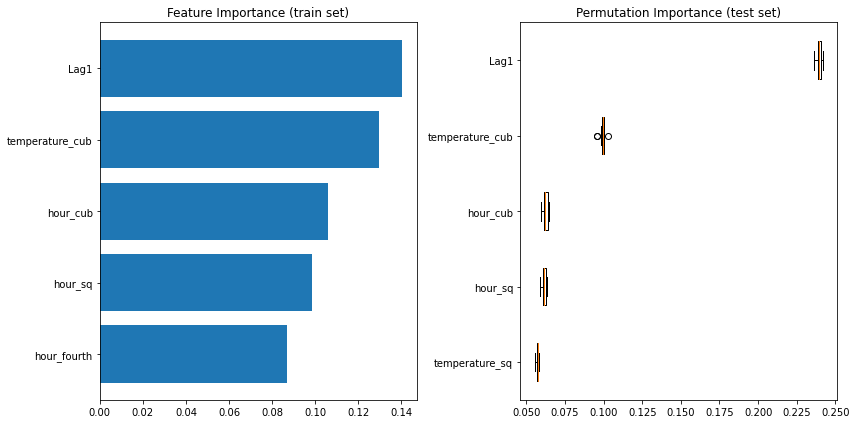

In [171]:
feature_importance = gbm_cv.feature_importances_
sorted_idx = np.argsort(feature_importance)[63:69]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (train set)')

result = permutation_importance(gbm_cv, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[63:69]
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Cross-Validated Random Forest

In [169]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for mb in [100,150,200]:
        for trees in [50,100,150]:
            for md in [2,4,6,8,10]:
                for features in ["auto","sqrt","log2"]:
                    rf = RandomForestRegressor(
                        min_samples_leaf=mb,
                        n_estimators=trees,
                        max_depth=md,
                        max_features=features)
                    rf.fit(X_tr, np.ravel(y_tr))
                    m,n = y_val.shape
                    y_val_pred = rf.predict(X_val).reshape((m,n))
                    SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                    train_mean = np.mean(y_tr.to_numpy())
                    SST = np.sum((train_mean - y_val_pred)**2)
                    OSR2 = 1 - (SSR/SST)
                    score.append([i,
                                mb,
                                trees,
                                md, 
                                features,
                                OSR2])
    i += 1

In [172]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "MinBucket",2:"Trees", 
                                            3:"Depth", 4:"Features", 5:"OSR2"})
cross_val = score.groupby(['MinBucket','Trees','Depth','Features']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    MinBucket  Trees  Depth Features      OSR2
12        100     50     10     auto  0.472685


In [173]:
rf_cv = RandomForestRegressor(min_samples_leaf=100, n_estimators=50, max_depth=10, 
                                max_features='auto').fit(X_train, np.ravel(y_train))
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = rf_cv.predict(X_test).reshape((m1,n1))
y_train_pred = rf_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.857115972853924
OS-R^2: 0.8193825172228784
IS-MAE: 535.0027625659613
OS-MAE: 646.4334430764698
IS-RMSE: 783.6159508427008
OS-RMSE: 930.3590951086394


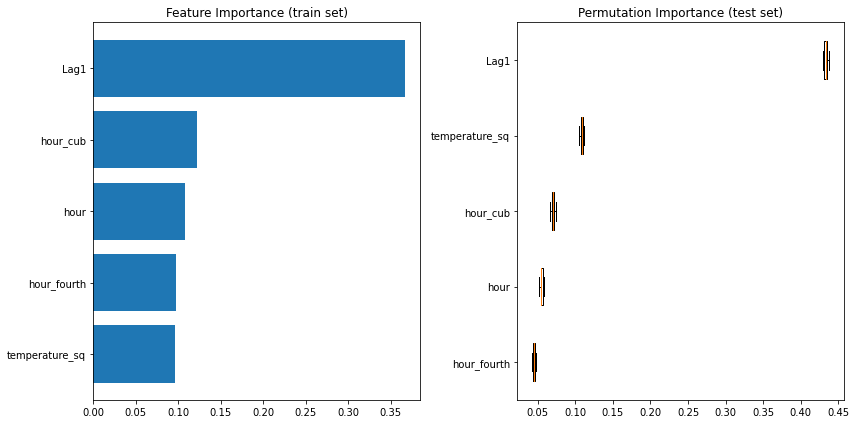

In [174]:
feature_importance = rf_cv.feature_importances_
sorted_idx = np.argsort(feature_importance)[63:69]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (train set)')

result = permutation_importance(rf_cv, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[63:69]
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()